In [73]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [74]:
# downloading a custom dataset of different foods - pizza,steak,sushi
# subset of food 101 dataset
import requests
import zipfile
from pathlib import Path
# make a local path in the kaggle env
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print("Directory already exists")
else:
    print("Creating directory")
    image_path.mkdir(parents=True, exist_ok=True)
# create a new zip file that stores the get request data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    # always use raw over blob when downloading from a github repo
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("retrieving data")
    f.write(request.content)
# unzip the data after it's written
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zipRef:
    print("unzipping data")
    zipRef.extractall(image_path)

Directory already exists
retrieving data
unzipping data


In [75]:
# data visualization before turning into tensors
import os
def walk_through_dir(dir_path, branch=None):
    full_path = os.path.join(dir_path, branch) if branch else dir_path
    for dirpath, dirnames, filenames in os.walk(full_path):
        print(f"{len(dirnames)} directories and {len(filenames)} imgs in {full_path}")

In [76]:
image_path

PosixPath('data/pizza_steak_sushi')

512
512


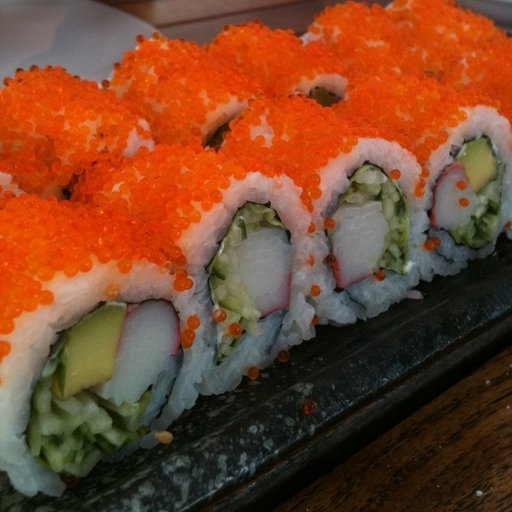

In [77]:
import random
from PIL import Image
random.seed(42)
# glob finds all pathnames matching a pattern
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_img_path = random.choice(image_path_list)
img_class = random_img_path.parent.stem

img = Image.open(random_img_path)
print(f"{img.height}")
print(f'{img.width}')
img

(-0.5, 511.5, 511.5, -0.5)

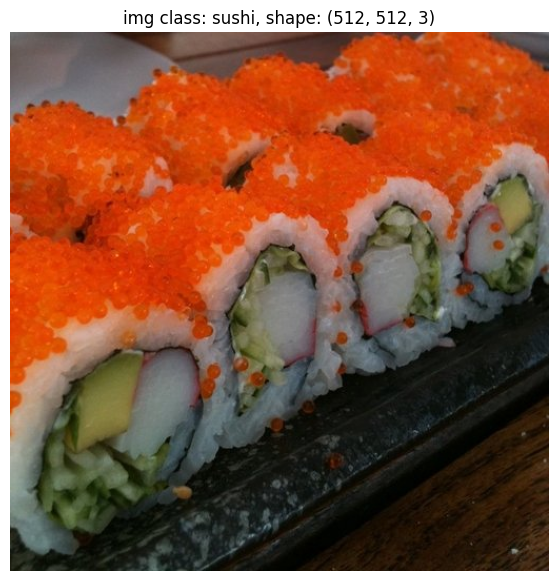

In [78]:
# image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt
# turn image into an array
img_as_arr = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_arr)
plt.title(f"img class: {img_class}, shape: {img_as_arr.shape}")
plt.axis(False)


In [79]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# turning image data into pytorch tensors
# then into a torch.utils.data.Dataset
# then into a torch.utils.data.DataLoader

# list of transforms to apply to the image
data_transforms = transforms.Compose([
    # matches TinyVGG architecture
    transforms.Resize(size=(64,64)),
    # half the imgs are flipped - increases training diversity
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn images into tensors
    transforms.ToTensor()
])
# pytorch is in the format color channels, width, height
data_transforms(img).shape

torch.Size([3, 64, 64])

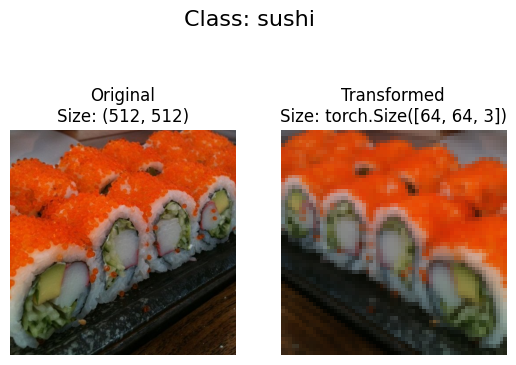

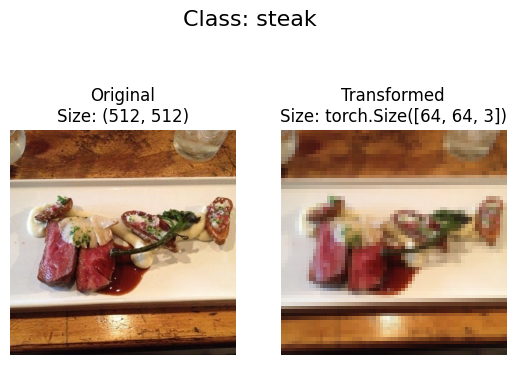

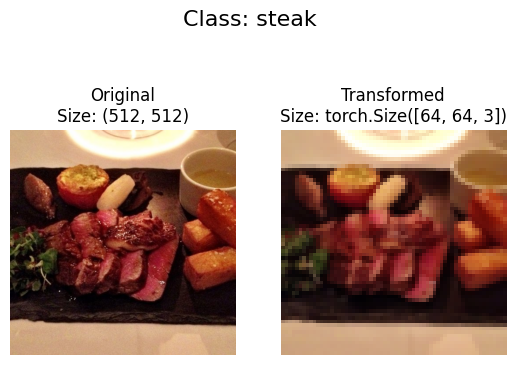

In [80]:
# plotting transformed images for further visualization
def plot_transformed_imgs(image_paths: list, transform, n=1, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as imgPtr:
            # first axis is original img
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(imgPtr)
            ax[0].set_title(f"Original\nSize: {imgPtr.size}")
            ax[0].axis(False)
            # second is transformed with dims switched for matplotlib
            transformed_image = transform(imgPtr).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_imgs(image_path_list, 
                        data_transforms,
                       3,
                       42)
            

In [81]:
from torchvision import datasets

train_dir = image_path / "train"
test_dir = image_path / "test"

train_data = datasets.ImageFolder(train_dir,data_transforms)
test_data = datasets.ImageFolder(test_dir, data_transforms)
classes = train_data.classes


In [82]:
# visualizing data from the dataset
# important for troubleshoot the 3 big errors
# device, shape and type mismatch
img, label = train_data[0][0], train_data[0][1]
img.shape, img.dtype, type(label)

(torch.Size([3, 64, 64]), torch.float32, int)

Text(0.5, 1.0, 'pizza')

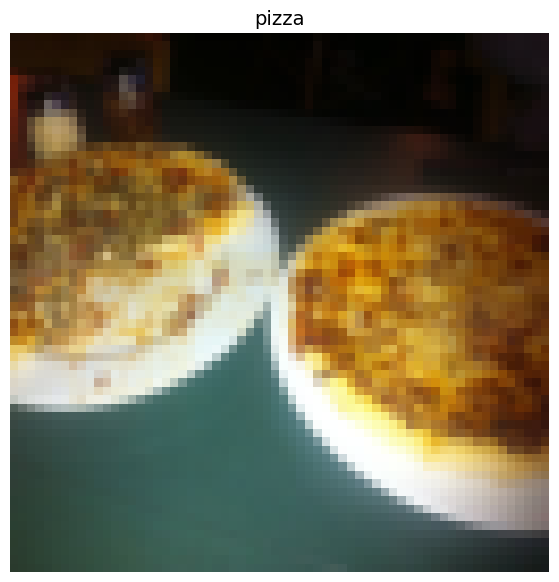

In [83]:
# visualizing with matplotlib from a dataset
# color channels last
img_permute = img.permute(1,2,0)
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(classes[label], fontsize=14)


In [84]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
# dataloader provides an iterable over a dataset basically
# specify parameter name when making a dataloader
dataLoader_Train = DataLoader(train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=True)
dataLoader_Test = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)
dataLoader_Train, dataLoader_Test

(<torch.utils.data.dataloader.DataLoader at 0x7d4206b93730>,
 <torch.utils.data.dataloader.DataLoader at 0x7d4206b93670>)

In [85]:
img, label = next((iter(dataLoader_Test)))
# dataloader adds a batch dimension
img.shape, label.shape


(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [86]:
# practice on using datasets without pre-built dataloaders
# should be able to load imgs, get classnames regularly and as a dict

import os
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [87]:
# replicatiing this functionality:
train_data.classes, train_data.class_to_idx
target_dir = train_dir

In [88]:
# retrieve classnames from the target directory
def retrieve_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"No classes in {directory}")
    else: 
        # return the classes, and a dictionary corresponding to their positions
        return classes, {name: i for i, name in enumerate(classes)}
retrieve_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [89]:
# creating a custom Dataset class
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transform=None):
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = retrieve_classes(target_dir)
        
    def load_img(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_img(index)
        # expects path in format data_folder/class_name/jpg
        class_name = self.paths[index].parent.name
        class_index = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img), class_index
        else:
            return img, class_index
        

In [90]:
# testing custom ImageFolder class
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

train_data_custom = ImageFolderCustom(target_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir, 
                                      transform=test_transforms)

train_data_custom.classes,
train_data_custom.classes == train_data.classes,
test_data_custom.classes == test_data.classes

True

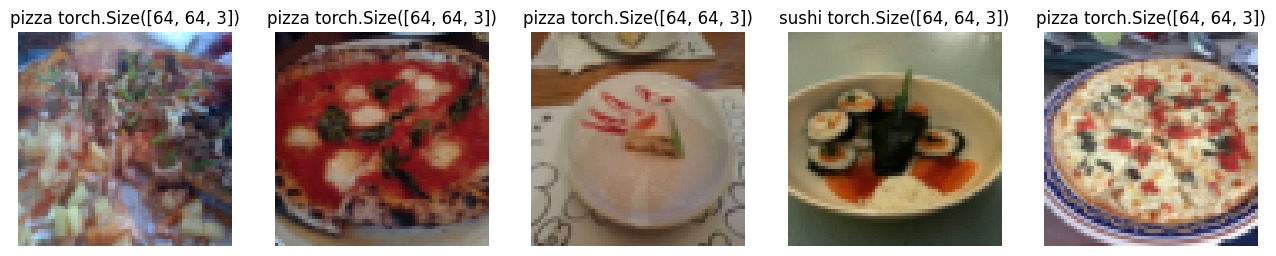

In [91]:
# more practice working with custom data visualization
def display_random_images(dSet: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         image_num:int = 10,
                         display_shape:bool = True,
                         seed: int = None):
    if image_num > 10:
        image_num = 10
        display_shape = False
        print("Image num capped at 10, removing shape display.")
    if seed:
        random.seed(seed)
    plt.figure(figsize=(16,8))
    # randomly sample 10 indices from the dataset
    random_samples = random.sample(range(len(dSet)), k=image_num)
    for i, target_sample in enumerate(random_samples):
        # grab image tensor data and label from the dataset
        target_image, target_label = dSet[target_sample][0], dSet[target_sample][1]
        # set up image dims for matplotlib
        target_image_adjusted = target_image.permute(1,2,0)
        # plot each image
        plt.subplot(1, image_num, i + 1)
        plt.imshow(target_image_adjusted)
        plt.axis(False)
        if classes:
            title = f"{classes[target_label]}"
            if display_shape:
                title = title + " " + f"{target_image_adjusted.shape}"
        plt.title(title)

display_random_images(dSet=train_data,
                     classes=train_data.classes,
                     image_num=5,
                     seed=None)

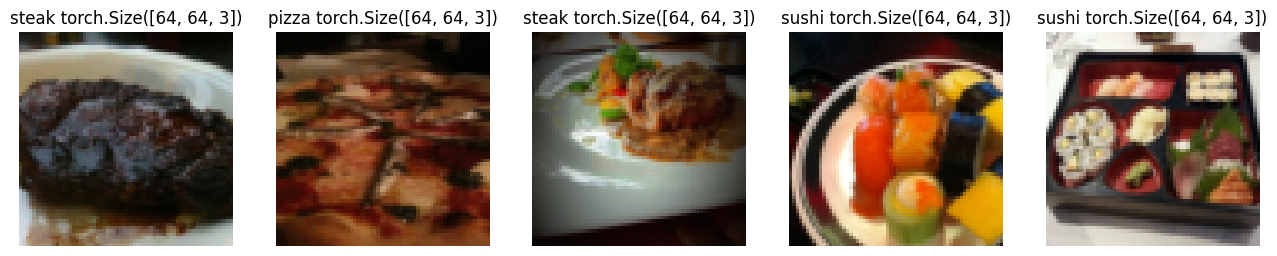

In [95]:
display_random_images(dSet=train_data_custom,
                     classes=train_data_custom.classes,
                     image_num=5,
                     )